In [1]:
! pip install torchinfo
! pip install torch_optimizer
from torchinfo import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import torch_optimizer as optim
import torch
from torch import nn
import torchvision
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.utils.random import sample_without_replacement
from IPython.display import Image, clear_output
from collections import defaultdict
from torch.optim import lr_scheduler
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
import time
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Предобработка данных

In [5]:
! ls drive/MyDrive/ds/3/

archive.zip  cheks  Testing  Training  val


In [6]:
# Путь до диска (для напоминания)
DISK_PATH = "drive/MyDrive"
# Путь до архива с данными (пример)
ZIP_PATH = "/content/drive/MyDrive/ds/3/archive.zip"
# Путь для папки с данными
DATA_PATH = "/content/drive/MyDrive/ds/3/"

In [7]:
!ls /content/drive/MyDrive/ds/3/

archive.zip  cheks  Testing  Training  val


In [8]:
!rm -rf /content/drive/MyDrive/ds/3/Training
!rm -rf /content/drive/MyDrive/ds/3/Testing
!rm -rf /content/drive/MyDrive/ds/3/val
!rm -rf /content/drive/MyDrive/ds/3/cheks/

In [ ]:
! unzip $ZIP_PATH -d  $DATA_PATH

In [10]:
! ls $DATA_PATH

archive.zip  Testing  Training


In [11]:
DATA_PATH = os.path.join(DATA_PATH)

### Подготовка датасетов

In [12]:

TRAIN_DIR = os.path.join(DATA_PATH, "Training")

TUMOR_LIST = {i:name for i, name in enumerate(os.listdir(TRAIN_DIR))}


VAL_DIR = os.path.join(DATA_PATH, "val")
os.makedirs(VAL_DIR, exist_ok=True)


TEST_DIR = os.path.join(DATA_PATH, "Testing")

VAL_FRAC = 0.3



In [13]:
for tumor in TUMOR_LIST.values():
    os.makedirs(os.path.join(VAL_DIR, tumor), exist_ok=True)


    tumor_path = os.path.join(TRAIN_DIR, tumor)

    # Сортируем изображения для детерминированнсти
    images_filename = sorted(os.listdir(tumor_path))

    # Выделяем часть изображений для валидации
    # Выбираем случайные изображения из выборки для валидции, с установленным random_state
    num_images = len(images_filename)
    num_val = int(num_images * VAL_FRAC)
    indices = sample_without_replacement(num_images, num_val, random_state=42)
    val_images = np.take(images_filename, indices)

    print(f'{tumor} | train images = {num_images - num_val} | val images = {num_val}')
    # Сохраняем валидационную выборку
    for image_filename in val_images:
        source = os.path.join(TRAIN_DIR, tumor, image_filename)
        destination = os.path.join(VAL_DIR, tumor, image_filename)
        shutil.copy(source, destination)
        os.remove(source)

glioma_tumor | train images = 579 | val images = 247
meningioma_tumor | train images = 576 | val images = 246
no_tumor | train images = 277 | val images = 118
pituitary_tumor | train images = 579 | val images = 248


In [14]:
!ls $TRAIN_DIR

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


In [15]:
!ls $VAL_DIR

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


In [16]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 4
BATCH_SIZE = 32
from torchvision import datasets

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = datasets.ImageFolder(TRAIN_DIR, transform=transform)
train_batch_gen = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = datasets.ImageFolder(VAL_DIR, transform=transform)
val_batch_gen = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = datasets.ImageFolder(TEST_DIR, transform=transform)
test_batch_gen = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
train_data[400][0].shape

torch.Size([3, 256, 256])

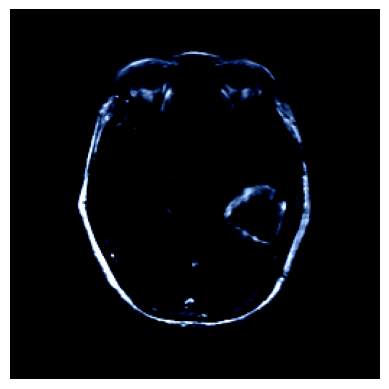

In [18]:
test_im = train_data[400][0].permute(1, 2, 0).numpy()
plt.imshow(test_im)
plt.axis("off");

In [19]:
label = next(iter(train_batch_gen))[1]

In [20]:
label, label.shape

(tensor([3, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 2, 3, 3, 1, 3,
         3, 3, 3, 2, 3, 3, 3, 0]),
 torch.Size([32]))

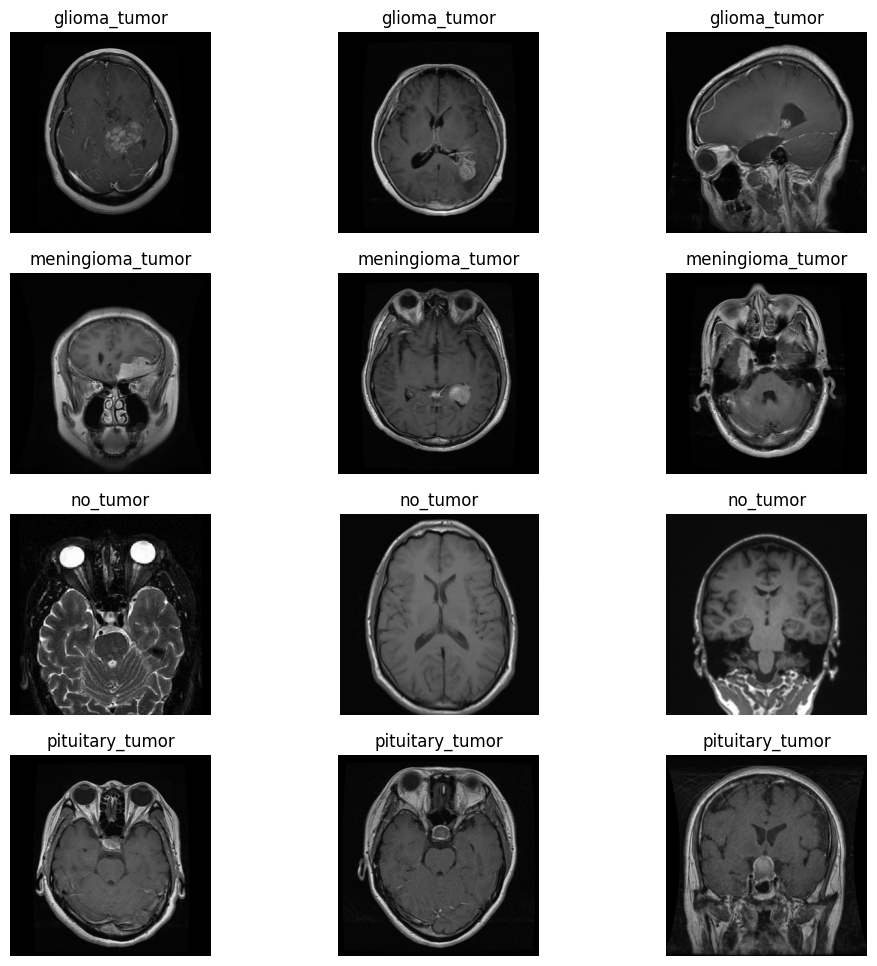

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

class_names = os.listdir(TRAIN_DIR)

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    image_files = os.listdir(class_dir)[:3]  # Выбираем первые 3 изображения из каждой категории

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        image = plt.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_name)
        axes[i, j].axis('off')


# model


In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.blocks = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size = 3,stride=stride, padding=1),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=False),
                                    nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=False))

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels))
        else:
            self.downsample = nn.Sequential()


    def forward(self, x):
        identity  = self.downsample(x)
        x = self.blocks(x)
        x = x + identity
        x = nn.functional.relu(x)
        return x


In [23]:
image_batch = torch.ones((3, 16, 67, 67))
block1 = ResidualBlock(16, 16, 1)
print(block1(image_batch).shape)
assert block1(image_batch).shape == (3, 16, 67, 67), 'Блок не должен менять размер изображения'

torch.Size([3, 16, 67, 67])


In [24]:
image_batch = torch.ones((3, 16, 64, 64))
block1 = ResidualBlock(16, 32, 2)
assert block1(image_batch).shape == (3, 32, 32, 32), 'Блок должен сжать изображение в 2 раза и увеличить количество выходных каналов до 32'

In [25]:
class ResNet(nn.Module):
    def __init__(self, num_classes, num_layers=None, layers_params=None):
        """
        param num_classes: количество классов, предсказываемых сетью
        param num_layers: список количества блоков с параметрами layers_params, которые будут добавлены в сеть
        param layers_params: список словарей параметров блоков
        """
        super().__init__()
        # количество классов для классификации
        self.num_classes = num_classes

        # дефолтные значения для примера
        if num_layers is None:
            num_layers = [1, 1, 1, 1, 1]
        if layers_params is None:
            layers_params = [
                {"in_channels": 16, "out_channels": 32, "stride": 2},
                {"in_channels": 32, "out_channels": 64, "stride": 2},
                {"in_channels": 64, "out_channels": 64, "stride": 1},
                {"in_channels": 64, "out_channels": 128, "stride": 2},
                {"in_channels": 128, "out_channels": 128, "stride": 1}
            ]

        assert len(num_layers) == len(layers_params), 'Размеры списков, задающих параметры сети, должны быть одинаковы'

        self.preprocess = nn.Sequential(nn.Conv2d(3, layers_params[0]["in_channels"], kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(layers_params[0]["in_channels"]),
                                        nn.ReLU(inplace=False))
        self.residual_blocks = nn.Sequential()
        for i, params in enumerate(layers_params):
            for j in range(num_layers[i]):
                if j == 0:
                    block = ResidualBlock(params['in_channels'], params['out_channels'], params['stride'])
                else:
                    block = ResidualBlock(params['out_channels'], params['out_channels'])
                self.residual_blocks.add_module(f"block_{i+1}_{j+1}", block)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        last_channels = layers_params[-1]['out_channels']
        self.fc = nn.Linear(last_channels, num_classes)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.residual_blocks(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = self.fc(x)
        return x

Проверьте, что сеть работает

In [26]:
resnet = ResNet(num_classes=4)
image_batch = torch.ones((3, 3, 36, 36))
temp = resnet(image_batch)
temp.shape

torch.Size([3, 4])

In [27]:
temp

tensor([[ 1.3359, -0.4601,  0.5077,  0.0800],
        [ 1.0983, -0.4335,  0.5665, -0.0613],
        [ 1.3040, -0.6191,  0.2076,  0.1259]], grad_fn=<AddmmBackward0>)

In [28]:
image_batch = torch.ones((3, 3, 132, 177))
resnet(image_batch).shape

torch.Size([3, 4])

In [29]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('f1', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.ylabel('f1', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

#обучение


In [30]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
from tqdm import tqdm
device

'cuda'

In [31]:
def train(model,criterion, optimizer, train_loader, val_loader,  num_epochs, checkpoints_dir=None, scheduler=None,train_aug=None, val_aug=None):
    '''
    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''
    history = defaultdict(lambda: defaultdict(list))
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    print(device)
    model = model.to(device)
    all_time = 0
    best_f1_macro = 0.0
    for epoch in range(num_epochs):
        train_loss = 0
        train_f1 = 0
        train_for_f1_b = []
        train_for_f1_p = []
        val_loss = 0
        val_f1 = 0
        val_for_f1_b = []
        val_for_f1_p = []
        start_time = time.time()
        model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            if train_aug:
                images = train_aug(images)
            logits = model(images)
            loss = criterion(logits, labels.long().to(device))
            loss.backward()
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()

            train_for_f1_b = np.append(train_for_f1_b, labels.cpu().numpy())
            train_for_f1_p = np.append(train_for_f1_p, y_pred)
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_batch_gen)
        train_f1 = f1_score(train_for_f1_b, train_for_f1_p, average="macro")
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                if val_aug:
                    images = val_aug(images)
                logits = model(images)

                loss1 = criterion(logits, labels)

                val_loss += loss1.detach().cpu().numpy()
                y_pred = logits.max(1)[1].detach().cpu().numpy()
                val_for_f1_b = np.append(val_for_f1_b, labels.cpu().numpy())
                val_for_f1_p = np.append(val_for_f1_p, y_pred)

        val_loss /= len(val_batch_gen)
        val_f1 = f1_score(val_for_f1_b, val_for_f1_p, average="macro")
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)
        clear_output()
        # Сохраняем лучшую модель по метрике F1-macro
        if checkpoints_dir and val_f1 > best_f1_macro:
            os.makedirs(checkpoints_dir, exist_ok=True)
            best_f1_macro = val_f1
            path = os.path.join(checkpoints_dir, 'best.checkpoint')
            torch.save(model.state_dict(), path)
        # Обновляем learning rate
        if scheduler:
            scheduler.step(val_loss)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training f1: \t\t\t{:.2f} %".format(train_f1 * 100))
        print(" validation f1: \t\t\t{:.2f} %".format(val_f1 * 100))
        plot_learning_curves(history)
        all_time += (time.time() - start_time)
    return model, history, all_time



In [32]:
num_layers = [2, 2, 2, 2,2]
layers_params = [
    {"in_channels": 16, "out_channels": 32, "stride": 2},
    {"in_channels": 32, "out_channels": 64, "stride": 2},
    {"in_channels": 64, "out_channels": 128, "stride": 2},
    {"in_channels": 128, "out_channels": 256, "stride": 2},
    {"in_channels": 256, "out_channels": 512, "stride": 2}
]

In [33]:
model = ResNet(num_classes=4,num_layers=num_layers,layers_params=layers_params).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Ranger(model.parameters(), lr=learning_rate)

checkpoints_dir = 'drive/MyDrive/ds/3/cheks'

Epoch 30 of 30 took 36.146s
 training loss (in-iteration): 	0.007183
 validation loss (in-iteration): 	0.511913
 training f1: 			99.91 %
 validation f1: 			83.23 %


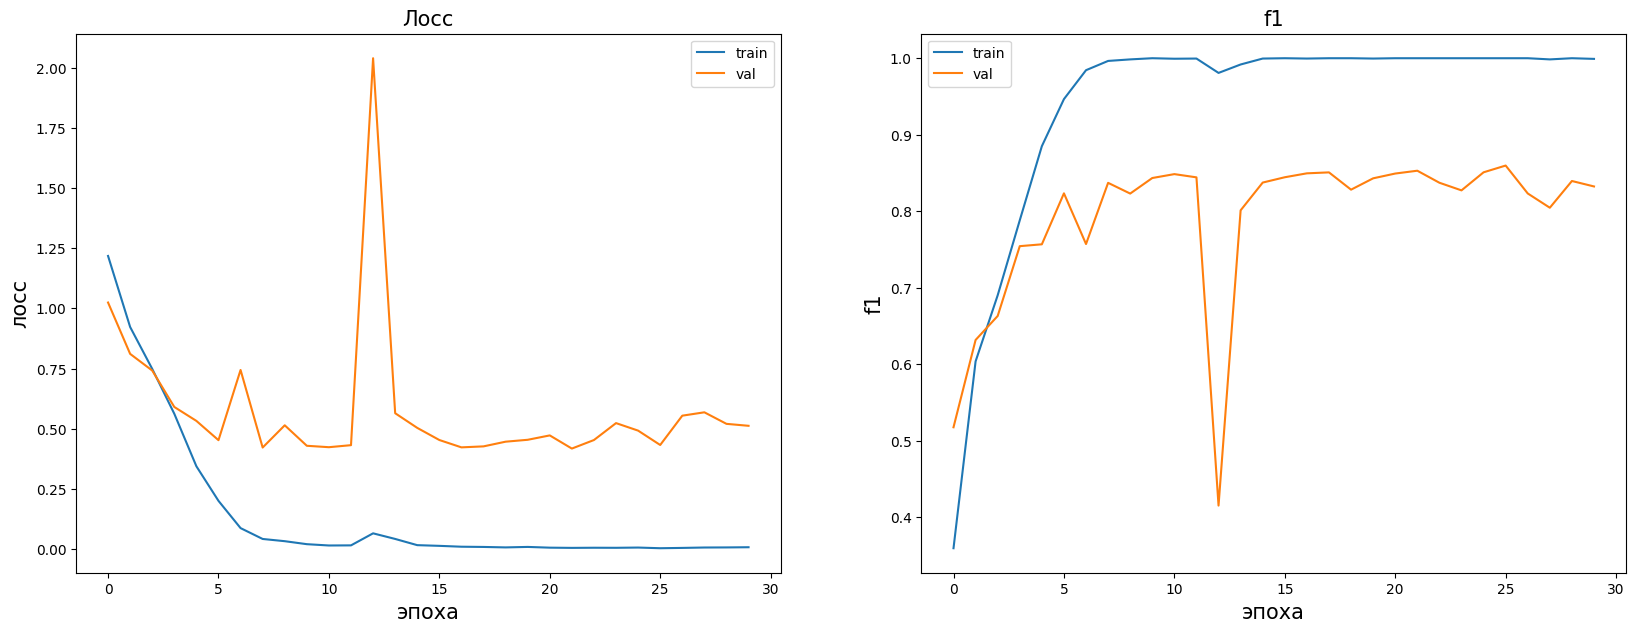

In [34]:
model, history, all_time = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=30, checkpoints_dir=checkpoints_dir,)

In [35]:
all_time

1116.4308550357819

# testing


In [ ]:
checkpoints_dir = 'drive/MyDrive/ds/3/cheks'

In [ ]:
path = os.path.join(checkpoints_dir, 'best.checkpoint')
state_dict = torch.load(path)

In [ ]:
# model = ResNet(num_classes=4,num_layers=num_layers,layers_params=layers_params).to(device)
# model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
y_b = []
y_p = []
for X_batch, y_batch in test_batch_gen:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, model(X_batch.to(device)).max(1)[1].detach().cpu().numpy())

In [37]:
test_f1_score = f1_score(y_b, y_p, average="macro")

test_f1_score

0.6099092011694347

# Что если дообучить готовы модели


In [38]:
learning_rate = 0.0001

In [39]:
from torchvision.models import resnet50

In [40]:
model = resnet50(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [ ]:
model

In [42]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=learning_rate)

Epoch 20 of 20 took 48.954s
 training loss (in-iteration): 	0.030295
 validation loss (in-iteration): 	0.123604
 training f1: 			99.01 %
 validation f1: 			95.43 %


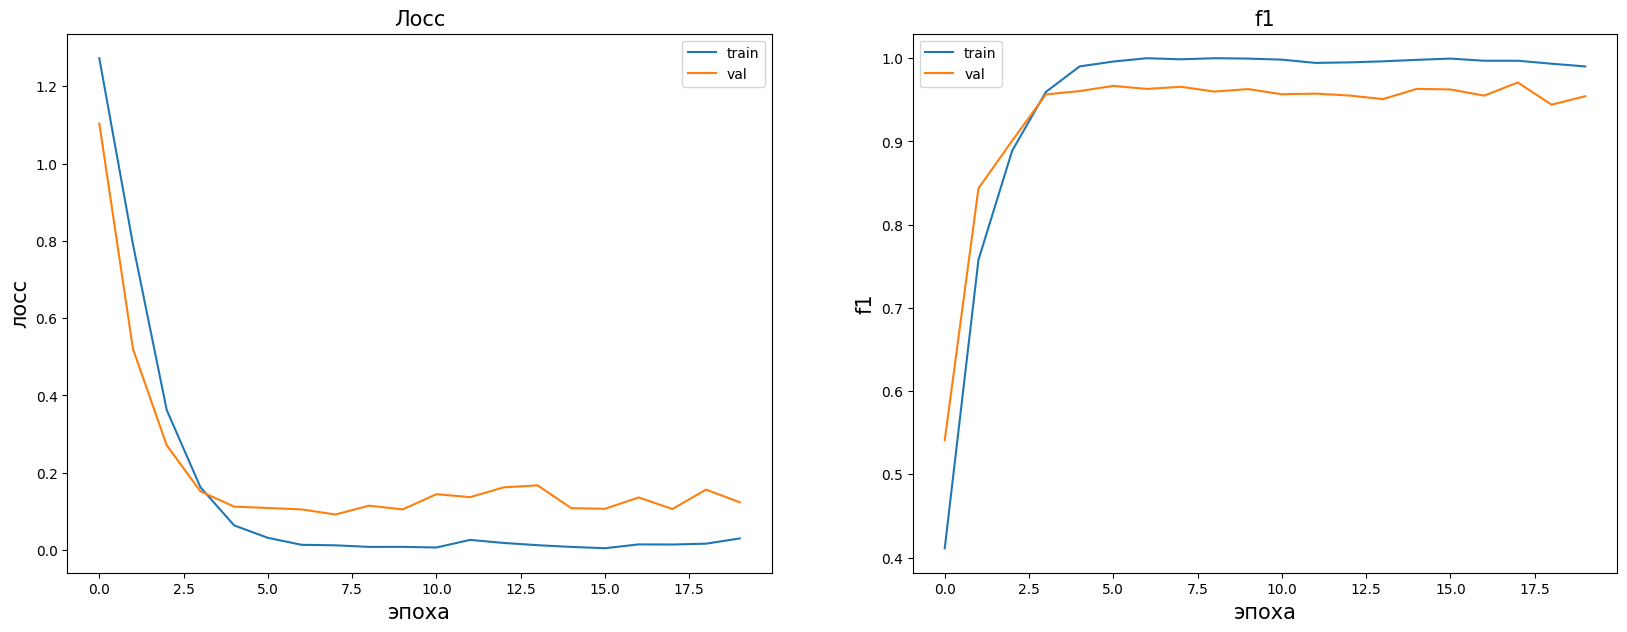

In [46]:
model, history, all_time = train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=20)

In [47]:
y_b = []
y_p = []
for X_batch, y_batch in test_batch_gen:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, model(X_batch.to(device)).max(1)[1].detach().cpu().numpy())

In [48]:
test_f1_score_ft = f1_score(y_b, y_p, average="macro")

test_f1_score_ft

0.7472759526901198

In [ ]:
from torchvision.models import efficientnet_b7

In [ ]:
model = efficientnet_b3(pretrained=True)

In [ ]:
model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('')
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 4))

In [ ]:
model

Epoch 20 of 20 took 49.938s
 training loss (in-iteration): 	0.019194
 validation loss (in-iteration): 	0.186829
 training f1: 			99.78 %
 validation f1: 			95.62 %


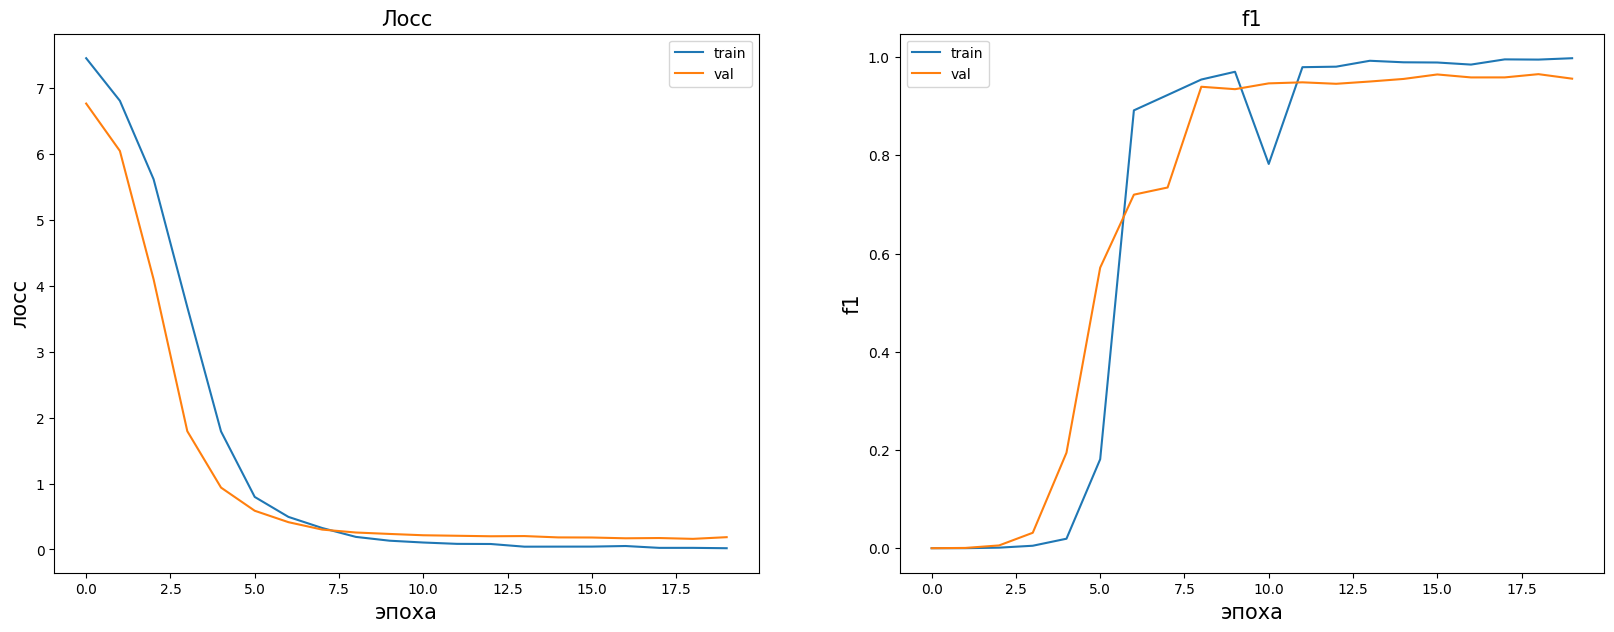

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=learning_rate)
model, history, all_time = train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=20)

In [ ]:
y_b = []
y_p = []
for X_batch, y_batch in test_batch_gen:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, model(X_batch.to(device)).max(1)[1].detach().cpu().numpy())
test_f1_score_ft = f1_score(y_b, y_p, average="macro")

In [ ]:
test_f1_score_ft

0.7566145069823533

In [ ]:
torch.cuda.empty_cache()